# Contrastive Models Analyzing CLIP (ViT-B/32) and Multimodal Biases

In [1]:
# --- 1. Installation and Imports ---
!pip install transformers torch torchvision tqdm

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from transformers import ViTForImageClassification, ViTImageProcessor
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

2025-09-24 23:45:13.837247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758757514.067187      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758757514.136909      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Zero-Shot Classification

### In-Domain Evaluation on Cifar-10

**Evaluate Baseline ViT**

In [2]:
# --- 2. Model and Device Setup ---
print("Setting up model and device...")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the baseline ViT model and its processor
baseline_model_name = "nateraw/vit-base-patch16-224-cifar10"
baseline_model = ViTForImageClassification.from_pretrained(baseline_model_name).to(device)
baseline_processor = ViTImageProcessor.from_pretrained(baseline_model_name)
print(f"Using device: {device}")
print("Baseline ViT model loaded successfully.")

Setting up model and device...


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Using device: cuda
Baseline ViT model loaded successfully.


In [3]:
# --- 3. Data Loading and Preparation ---
# Load the dataset with raw PIL Images
cifar10_test_pil = CIFAR10(root=".", download=True, train=False)
class_names = cifar10_test_pil.classes

# Define a custom collate function to use the processor on batches of PIL images
def collate_fn_baseline(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    inputs = baseline_processor(images=images, return_tensors="pt")
    inputs['labels'] = torch.tensor(labels)
    return inputs

# Create the DataLoader with our custom function
test_dataloader_baseline = DataLoader(cifar10_test_pil, batch_size=64, collate_fn=collate_fn_baseline)
print("CIFAR-10 test set prepared.")

100%|██████████| 170M/170M [00:10<00:00, 17.0MB/s] 


CIFAR-10 test set prepared.


In [14]:
# --- 4. Evaluation Loop ---
print("\nStarting evaluation of the baseline ViT model...")
baseline_model.eval()
correct_predictions = 0
total_images = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader_baseline, desc="Evaluating Baseline ViT"):
        # Move the entire batch to the correct device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        
        # Get model outputs (logits)
        outputs = baseline_model(**batch)
        logits = outputs.logits
        
        # Get predictions
        predictions = torch.argmax(logits, dim=-1)
        
        # Check for correctness
        correct_predictions += (predictions == labels).sum().item()
        total_images += len(labels)

# --- 5. Report Final Accuracy ---
accuracy = (correct_predictions / total_images) * 100
print(f"\n Baseline ViT Accuracy on CIFAR-10: {accuracy:.2f}%")


Starting evaluation of the baseline ViT model...


Evaluating Baseline ViT: 100%|██████████| 157/157 [02:34<00:00,  1.01it/s]


 Baseline ViT Accuracy on CIFAR-10: 98.52%


**Evaluate CLIP on CIFAR-10 (Prompt Ensembling)**

In [4]:
# --- 1. Installation and Imports ---
# (Assumes libraries are already installed from the previous step)
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import numpy as np

In [5]:
# --- 2. Model and Device Setup ---
print("Setting up CLIP model and device...")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and its processor
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
print(f"Using device: {device}")
print("CLIP model loaded successfully.")

Setting up CLIP model and device...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Using device: cuda
CLIP model loaded successfully.


In [6]:
# --- 3. Prompt Ensembling Setup ---
# Define multiple descriptive prompts for each class
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
prompt_templates = [
    "a photo of a {}.",
    "a blurry photo of a {}.",
    "a black and white photo of a {}.",
    "a low-resolution photo of a {}.",
    "a cropped photo of a {}.",
    "a bright photo of a {}.",
    "a dark photo of a {}.",
    "a close-up photo of a {}.",
    "a painting of a {}.",
    "a sketch of a {}.",
    "a drawing of a {}.",
    "a computer animation of a {}.",
    "a video game screenshot of a {}.",
    "the word {}.",
    "a toy {}.",
    "a {}.",
]

print("\nCreating ensembled text features...")
ensembled_features = []
with torch.no_grad():
    for class_name in cifar10_classes:
        # Create all prompts for the current class
        prompts = [template.format(class_name) for template in prompt_templates]
        
        # Tokenize and get features for all prompts
        text_inputs = clip_processor(text=prompts, return_tensors="pt", padding=True).to(device)
        class_features = clip_model.get_text_features(**text_inputs)
        
        # Normalize and average the features
        class_features /= class_features.norm(dim=-1, keepdim=True)
        ensembled_feature = class_features.mean(dim=0)
        
        # Store the final ensembled feature for this class
        ensembled_features.append(ensembled_feature)

# Stack all ensembled features into a single tensor
ensembled_text_features = torch.stack(ensembled_features)
ensembled_text_features /= ensembled_text_features.norm(dim=-1, keepdim=True)
print("Ensembled text features created successfully.")


Creating ensembled text features...
Ensembled text features created successfully.


In [7]:
# --- 4. Data Loading for CLIP ---
# Define the transform pipeline required by CLIP
image_mean = clip_processor.image_processor.image_mean
image_std = clip_processor.image_processor.image_std
transform_clip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

# Load CIFAR-10 with the CLIP-specific transforms
cifar10_test_clip = CIFAR10(root=".", download=True, train=False, transform=transform_clip)
test_dataloader_clip = DataLoader(cifar10_test_clip, batch_size=64)
print("\nCIFAR-10 test set prepared for CLIP.")


CIFAR-10 test set prepared for CLIP.


In [20]:
# --- 5. Evaluation Loop with Ensembled Features ---
print("Starting evaluation of CLIP with prompt ensembling...")
clip_model.eval()
correct_predictions = 0
total_images = 0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader_clip, desc="Evaluating CLIP"):
        images = images.to(device)
        
        # Get image features
        image_features = clip_model.get_image_features(pixel_values=images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity against the ENSEMBLED text features
        similarity = (100.0 * image_features @ ensembled_text_features.T)
        predictions = similarity.argmax(dim=-1)
        
        # Check for correctness
        correct_predictions += (predictions == torch.tensor(labels).to(device)).sum().item()
        total_images += images.size(0)

# --- 6. Report Final Accuracy ---
accuracy = (correct_predictions / total_images) * 100
print(f"\n✅ CLIP Accuracy on CIFAR-10 (with Prompt Ensembling): {accuracy:.2f}%")

Starting evaluation of CLIP with prompt ensembling...


Evaluating CLIP:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_36/1243452756.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct_predictions += (predictions == torch.tensor(labels).to(device)).sum().item()
Evaluating CLIP: 100%|██████████| 157/157 [00:46<00:00,  3.39it/s]


✅ CLIP Accuracy on CIFAR-10 (with Prompt Ensembling): 87.89%


### Out-of-Distribution (OOD) Evaluation on PACS

**Preparing the PACS Dataset**

In [8]:
# --- 1. Install the 'datasets' library ---
!pip install datasets

from datasets import load_dataset

# --- 2. Load the PACS dataset from Hugging Face ---
# We'll use the 'train' split as it contains all the images.
print("Loading PACS dataset from Hugging Face...")
pacs_dataset = load_dataset("flwrlabs/pacs", split='train')
print("Dataset loaded successfully.")

# --- 3. Filter for the 'sketch' domain ---
# The dataset has a 'domain' column. We select only the rows where the domain is 'sketch'.
print("Filtering for the 'sketch' domain...")
sketch_dataset = pacs_dataset.filter(lambda example: example["domain"] == "sketch")
print(f"Found {len(sketch_dataset)} images in the sketch domain.")

# --- 4. Get the Class Names ---
# The class names are stored in the dataset's features.
pacs_class_names = sketch_dataset.features['label'].names
print(f"\nClasses in PACS dataset: {pacs_class_names}")

# Let's inspect one example to see the structure
print("\nExample data point from the sketch dataset:")
print(sketch_dataset[0])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Loading PACS dataset from Hugging Face...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Dataset loaded successfully.
Filtering for the 'sketch' domain...


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Found 3929 images in the sketch domain.

Classes in PACS dataset: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

Example data point from the sketch dataset:
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=227x227 at 0x7F3E6120F5D0>, 'domain': 'sketch', 'label': 0}


**Evaluate Baseline ViT on the PACS Sketches**

In [24]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- 1. Define a Collate Function for the PACS dataset ---
# This function will process batches of data from the Hugging Face dataset object.
def collate_fn_pacs(batch):
    # The 'image' field contains PIL Images, 'label' has the integer labels.
    images = [item['image'] for item in batch]
    labels = [item['label'] for item in batch]
    
    # Use the baseline_processor to prepare the images
    inputs = baseline_processor(images=images, return_tensors="pt")
    
    # Add the labels to the batch
    inputs['labels'] = torch.tensor(labels)
    return inputs

# --- 2. Create the DataLoader ---
pacs_sketch_dataloader = DataLoader(sketch_dataset, batch_size=64, collate_fn=collate_fn_pacs)

# --- 3. Evaluation Loop ---
print("Starting evaluation of the baseline ViT on PACS sketches...")
baseline_model.eval()
correct_predictions = 0
total_images = 0

with torch.no_grad():
    for batch in tqdm(pacs_sketch_dataloader, desc="Evaluating Baseline on Sketches"):
        # Move the batch to the correct device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        
        # Get model outputs (logits)
        # Note: The model will output predictions for 10 CIFAR classes, not the 7 PACS classes.
        outputs = baseline_model(**batch)
        logits = outputs.logits
        
        # Get predictions
        predictions = torch.argmax(logits, dim=-1)
        
        # Check for correctness (we expect this to be very low)
        correct_predictions += (predictions == labels).sum().item()
        total_images += len(labels)

# --- 4. Report Final Accuracy ---
accuracy = (correct_predictions / total_images) * 100
print(f"\n✅ Baseline ViT Accuracy on PACS Sketches (OOD): {accuracy:.2f}%")

Starting evaluation of the baseline ViT on PACS sketches...


Evaluating Baseline on Sketches: 100%|██████████| 62/62 [01:00<00:00,  1.02it/s]


✅ Baseline ViT Accuracy on PACS Sketches (OOD): 7.28%


**Evaluate CLIP on PACS Sketches**

In [9]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- 1. Create Text Prompts for PACS Classes ---
# We'll use a prompt style that is appropriate for the sketch domain.
pacs_prompts = [f"a sketch of a {name}" for name in pacs_class_names]

# Get the text features for these prompts from CLIP
with torch.no_grad():
    text_inputs = clip_processor(text=pacs_prompts, return_tensors="pt", padding=True).to(device)
    pacs_text_features = clip_model.get_text_features(**text_inputs)
    # Normalize the text features
    pacs_text_features /= pacs_text_features.norm(dim=-1, keepdim=True)

# --- 2. Define a Collate Function for CLIP and PACS ---
def collate_fn_clip_pacs(batch):
    # This function processes batches for CLIP's image encoder
    images = [item['image'] for item in batch]
    labels = [item['label'] for item in batch]
    
    # Use the CLIP processor to prepare the images
    inputs = clip_processor(images=images, return_tensors="pt", padding=True)
    
    # Add the labels to the batch
    inputs['labels'] = torch.tensor(labels)
    return inputs

# --- 3. Create the DataLoader ---
pacs_sketch_dataloader_clip = DataLoader(sketch_dataset, batch_size=64, collate_fn=collate_fn_clip_pacs)

In [27]:
# --- 4. Evaluation Loop ---
print("Starting zero-shot evaluation of CLIP on PACS sketches...")
clip_model.eval()
correct_predictions = 0
total_images = 0

with torch.no_grad():
    for batch in tqdm(pacs_sketch_dataloader_clip, desc="Evaluating CLIP on Sketches"):
        # The collate_fn already processed the images, just move to device
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        # Get image features
        image_features = clip_model.get_image_features(pixel_values=pixel_values)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity against the PACS text features
        similarity = (100.0 * image_features @ pacs_text_features.T)
        predictions = similarity.argmax(dim=-1)
        
        # Check for correctness
        correct_predictions += (predictions == labels).sum().item()
        total_images += len(labels)

# --- 5. Report Final Accuracy ---
accuracy = (correct_predictions / total_images) * 100
print(f"\n✅ CLIP Zero-Shot Accuracy on PACS Sketches (OOD): {accuracy:.2f}%")

Starting zero-shot evaluation of CLIP on PACS sketches...


Evaluating CLIP on Sketches: 100%|██████████| 62/62 [00:25<00:00,  2.41it/s]


✅ CLIP Zero-Shot Accuracy on PACS Sketches (OOD): 85.09%


**Comparing Results**

In [30]:
import pandas as pd
from IPython.display import display

# --- 1. Create a dictionary with your results ---
data = {
    'Model': ['Baseline ViT (Supervised)', 'CLIP (Zero-Shot)'],
    'In-Domain Accuracy (CIFAR-10)': [98.52, 87.89],
    'Out-of-Distribution Accuracy (PACS Sketches)': [7.28, 85.09]
}

# --- 2. Create a pandas DataFrame ---
results_df = pd.DataFrame(data)
results_df = results_df.set_index('Model') # Set the 'Model' column as the row index

# --- 3. Format the numbers to include a '%' sign ---
formatted_df = results_df.style.format("{:.2f}%")

# --- 4. Display the formatted table ---
display(formatted_df)

,In-Domain Accuracy (CIFAR-10),Out-of-Distribution Accuracy (PACS Sketches)
Model,,
Baseline ViT (Supervised),98.52%,7.28%
CLIP (Zero-Shot),87.89%,85.09%


## Few-Shot or Prompt Engineering

In [10]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- 1. Define a list of prompt templates to test ---
# As suggested by the manual, we'll try different phrasings.
prompt_templates = [
    "a photo of a {}",      # The standard prompt
    "a high-quality photo of a {}", # A more descriptive prompt
    "an image of a {}",      # A neutral alternative
    "a sketch of a {}",     # A stylistically mismatched prompt
    "{}"                    # The simplest possible prompt
]

# --- 2. Re-use the CIFAR-10 DataLoader for CLIP ---
# This uses the dataset with the correct transforms (Resize, ToTensor, Normalize)
test_dataloader_clip = DataLoader(cifar10_test_clip, batch_size=64)

results = {}

In [32]:
# --- 3. Loop through each template and evaluate CLIP ---
for template in prompt_templates:
    print(f"\n--- Evaluating with prompt template: '{template}' ---")
    
    # Create the specific text prompts for this run
    class_names = cifar10_test_clip.classes
    text_prompts = [template.format(name) for name in class_names]
    text_inputs = clip_processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
    
    # --- Evaluation Loop ---
    clip_model.eval()
    correct_predictions = 0
    total_images = 0

    with torch.no_grad():
        for images, labels in tqdm(test_dataloader_clip, desc="Evaluating"):
            images = images.to(device)
            
            # Get features
            image_features = clip_model.get_image_features(pixel_values=images)
            text_features = clip_model.get_text_features(**text_inputs)
            
            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
            # Calculate similarity and get predictions
            similarity = (100.0 * image_features @ text_features.T)
            predictions = similarity.argmax(dim=-1)
            
            # Check correctness
            correct_predictions += (predictions == torch.tensor(labels).to(device)).sum().item()
            total_images += images.size(0)

    # Calculate and store the accuracy
    accuracy = (correct_predictions / total_images) * 100
    results[template] = accuracy
    print(f"Accuracy: {accuracy:.2f}%")

# --- 4. Display the final comparison ---
print("\n--- Prompt Engineering Results ---")
for template, acc in results.items():
    print(f"Template: '{template.ljust(35)}' | Accuracy: {acc:.2f}%")


--- Evaluating with prompt template: 'a photo of a {}' ---


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipykernel_36/767033976.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct_predictions += (predictions == torch.tensor(labels).to(device)).sum().item()
Evaluating: 100%|██████████| 157/157 [00:47<00:00,  3.33it/s]


Accuracy: 87.83%

--- Evaluating with prompt template: 'a high-quality photo of a {}' ---


Evaluating: 100%|██████████| 157/157 [00:47<00:00,  3.29it/s]


Accuracy: 87.83%

--- Evaluating with prompt template: 'an image of a {}' ---


Evaluating: 100%|██████████| 157/157 [00:47<00:00,  3.31it/s]


Accuracy: 86.78%

--- Evaluating with prompt template: 'a sketch of a {}' ---


Evaluating: 100%|██████████| 157/157 [00:47<00:00,  3.33it/s]


Accuracy: 87.26%

--- Evaluating with prompt template: '{}' ---


Evaluating: 100%|██████████| 157/157 [00:46<00:00,  3.35it/s]

Accuracy: 84.96%

--- Prompt Engineering Results ---
Template: 'a photo of a {}                    ' | Accuracy: 87.83%
Template: 'a high-quality photo of a {}       ' | Accuracy: 87.83%
Template: 'an image of a {}                   ' | Accuracy: 86.78%
Template: 'a sketch of a {}                   ' | Accuracy: 87.26%
Template: '{}                                 ' | Accuracy: 84.96%


## Image-Text Retrieval

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# --- 1. Gather a New, Randomized Set of Assets ---

# Randomly select 10 photos from CIFAR-10 and 10 sketches from PACS
num_cifar_samples = len(cifar10_test_pil)
random_cifar_indices = random.sample(range(num_cifar_samples), 10)
cifar_images_rand = [cifar10_test_pil[i][0] for i in random_cifar_indices]
cifar_labels_rand = [cifar10_test_pil.classes[cifar10_test_pil[i][1]] for i in random_cifar_indices]

num_pacs_samples = len(sketch_dataset)
random_pacs_indices = random.sample(range(num_pacs_samples), 10)
pacs_images_rand = [sketch_dataset[i]['image'] for i in random_pacs_indices]
pacs_labels_rand = [pacs_class_names[sketch_dataset[i]['label']] for i in random_pacs_indices]

# Combine into a new gallery of 20 images
gallery_images = cifar_images_rand + pacs_images_rand
gallery_labels = cifar_labels_rand + pacs_labels_rand

# --- 2. Dynamically Create Text Queries Based on the Gallery ---

# Find the unique class names in our randomly selected gallery
unique_labels_in_gallery = sorted(list(set(gallery_labels)))
print(f"Unique classes in our random gallery: {unique_labels_in_gallery}")

# Create a text query for each unique class. We'll generate two styles of prompts.
text_queries = [f"a photo of a {label}" for label in unique_labels_in_gallery] + \
               [f"a sketch of a {label}" for label in unique_labels_in_gallery]

print(f"Dynamically created {len(text_queries)} text queries.")

Unique classes in our random gallery: ['airplane', 'automobile', 'cat', 'deer', 'dog', 'elephant', 'frog', 'giraffe', 'guitar', 'horse', 'ship']
Dynamically created 22 text queries.


In [12]:
# --- 3. Compute All Embeddings ---

clip_model.eval()
with torch.no_grad():
    image_inputs = clip_processor(images=gallery_images, return_tensors="pt", padding=True).to(device)
    gallery_image_features = clip_model.get_image_features(pixel_values=image_inputs['pixel_values'])
    gallery_image_features /= gallery_image_features.norm(dim=-1, keepdim=True)
    
    text_inputs = clip_processor(text=text_queries, return_tensors="pt", padding=True).to(device)
    gallery_text_features = clip_model.get_text_features(**text_inputs)
    gallery_text_features /= gallery_text_features.norm(dim=-1, keepdim=True)



--- Text-to-Image Retrieval Results (Dynamic Queries) ---


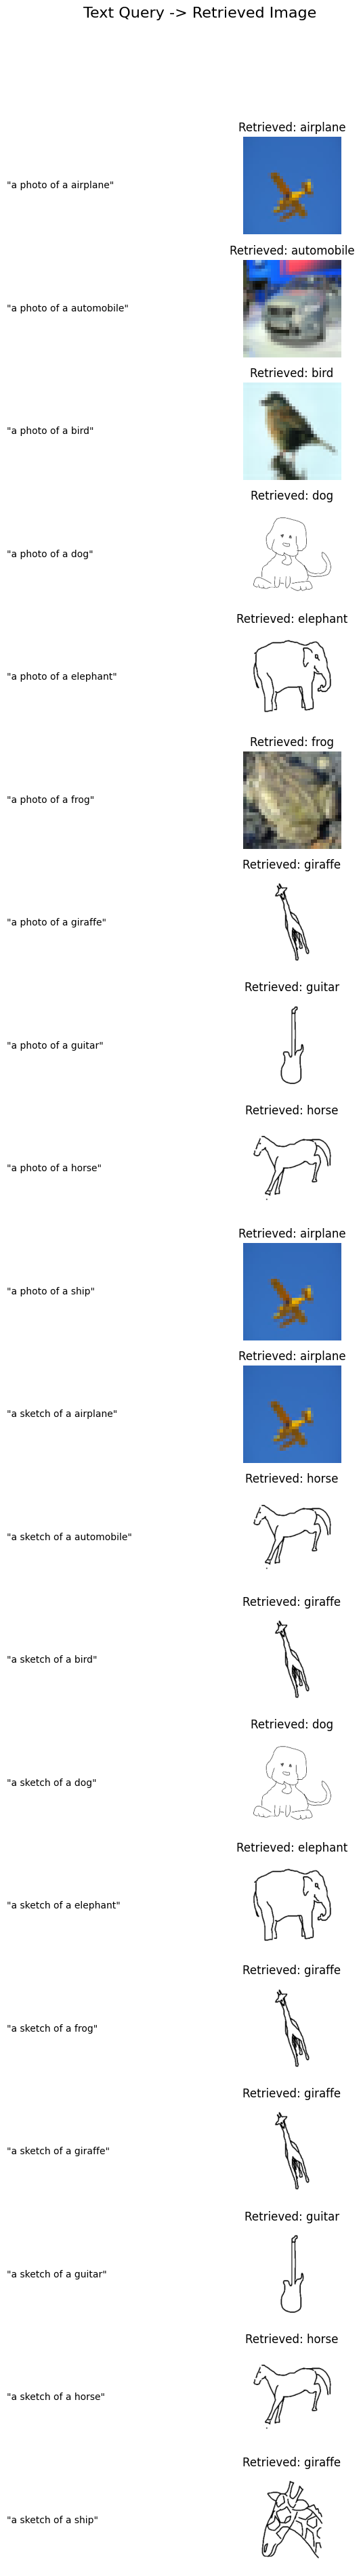

In [48]:
# --- 4. Perform Text-to-Image and Image-to-Text Retrieval ---
# (The retrieval and plotting code is the same as the previous step)

# Text-to-Image
text_to_image_similarity = gallery_text_features @ gallery_image_features.T
best_image_indices = text_to_image_similarity.argmax(dim=-1)

print("\n--- Text-to-Image Retrieval Results (Dynamic Queries) ---")
fig, axes = plt.subplots(len(text_queries), 2, figsize=(6, 2 * len(text_queries))) # Dynamic height
fig.suptitle("Text Query -> Retrieved Image", fontsize=16)
for i, query in enumerate(text_queries):
    retrieved_idx = best_image_indices[i].item()
    axes[i, 0].text(0, 0.5, f'"{query}"', ha='left', va='center', wrap=True)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(gallery_images[retrieved_idx])
    axes[i, 1].set_title(f"Retrieved: {gallery_labels[retrieved_idx]}")
    axes[i, 1].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Image-to-Text Retrieval Results (Dynamic Queries) ---


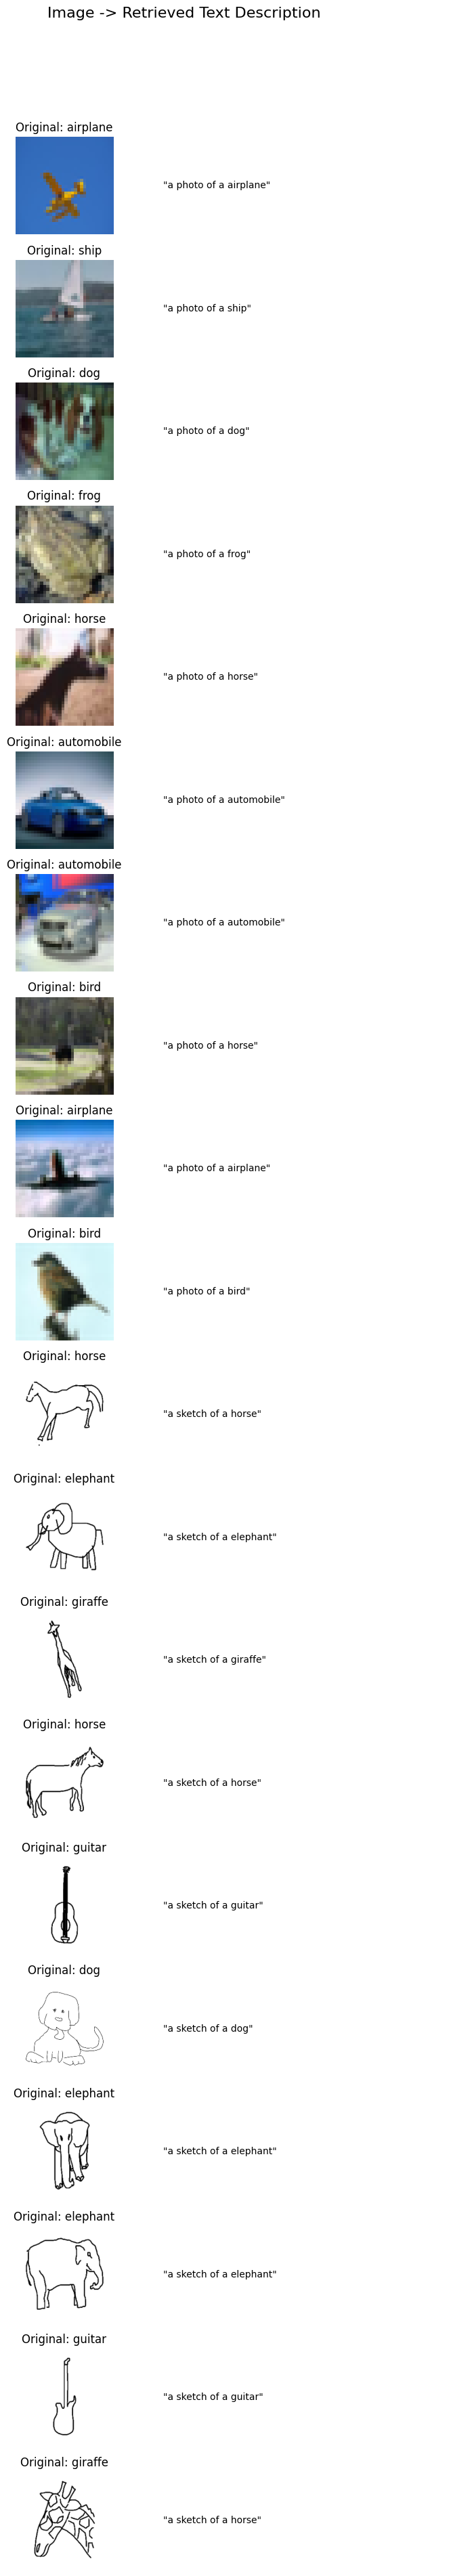

In [49]:
# Image-to-Text
image_to_text_similarity = gallery_image_features @ gallery_text_features.T
best_text_indices = image_to_text_similarity.argmax(dim=-1)

print("\n--- Image-to-Text Retrieval Results (Dynamic Queries) ---")
fig, axes = plt.subplots(len(gallery_images), 2, figsize=(8, 40))
fig.suptitle("Image -> Retrieved Text Description", fontsize=16)
for i, image in enumerate(gallery_images):
    retrieved_idx = best_text_indices[i].item()
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original: {gallery_labels[i]}")
    axes[i, 0].axis('off')
    axes[i, 1].text(0, 0.5, f'"{text_queries[retrieved_idx]}"', ha='left', va='center', wrap=True)
    axes[i, 1].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Representation Analysis - Image-Only

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from tqdm import tqdm

# --- 1. Gather a Diverse Image Set ---
print("Step 1: Gathering a diverse set of images...")
n_samples_per_domain = 150
image_set = []
label_set = [] # Will store integer labels
domain_set = [] # 0 for photo, 1 for sketch

# Create a unified list of all possible class names
all_class_names = sorted(list(set(cifar10_test_pil.classes + pacs_class_names)))
# Create a mapping from class name to a unique integer index
class_to_idx = {name: i for i, name in enumerate(all_class_names)}

# Gather 150 random photos from CIFAR-10
num_cifar_samples = len(cifar10_test_pil)
random_cifar_indices = random.sample(range(num_cifar_samples), n_samples_per_domain)
for i in random_cifar_indices:
    img, label_idx = cifar10_test_pil[i]
    class_name = cifar10_test_pil.classes[label_idx]
    image_set.append(img)
    label_set.append(class_to_idx[class_name])
    domain_set.append(0)

# Gather 150 random sketches from PACS
num_pacs_samples = len(sketch_dataset)
random_pacs_indices = random.sample(range(num_pacs_samples), n_samples_per_domain)
for i in random_pacs_indices:
    example = sketch_dataset[i]
    class_name = pacs_class_names[example['label']]
    image_set.append(example['image'])
    label_set.append(class_to_idx[class_name])
    domain_set.append(1)

print(f"Gathered {len(image_set)} total images.")

Step 1: Gathering a diverse set of images...
Gathered 300 total images.


In [14]:
# --- 2. Extract Embeddings from Both Models ---
print("\nStep 2: Extracting embeddings from models...")
clip_embeddings = []
baseline_embeddings = []

# Process in batches for efficiency
batch_size = 32
with torch.no_grad():
    for i in tqdm(range(0, len(image_set), batch_size), desc="Extracting Embeddings"):
        batch_images = image_set[i:i+batch_size]
        
        # Get CLIP embeddings
        inputs_clip = clip_processor(images=batch_images, return_tensors="pt", padding=True).to(device)
        clip_output = clip_model.get_image_features(pixel_values=inputs_clip['pixel_values'])
        clip_embeddings.append(clip_output.cpu())

        # Get Baseline ViT embeddings (penultimate layer)
        inputs_baseline = baseline_processor(images=batch_images, return_tensors="pt").to(device)
        baseline_output = baseline_model(**inputs_baseline, output_hidden_states=True)
        # For ViT, the [CLS] token of the last hidden state is the embedding
        baseline_cls_embedding = baseline_output.hidden_states[-1][:, 0, :].cpu()
        baseline_embeddings.append(baseline_cls_embedding)

clip_embeddings = torch.cat(clip_embeddings).numpy()
baseline_embeddings = torch.cat(baseline_embeddings).numpy()


Step 2: Extracting embeddings from models...


Extracting Embeddings: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


In [15]:
# --- 3. Apply t-SNE Dimensionality Reduction ---
print("\nStep 3: Running t-SNE... (This can be slow)")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
clip_2d = tsne.fit_transform(clip_embeddings)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
baseline_2d = tsne.fit_transform(baseline_embeddings)
print("t-SNE complete.")


Step 3: Running t-SNE... (This can be slow)
t-SNE complete.



Step 4: Generating plots...


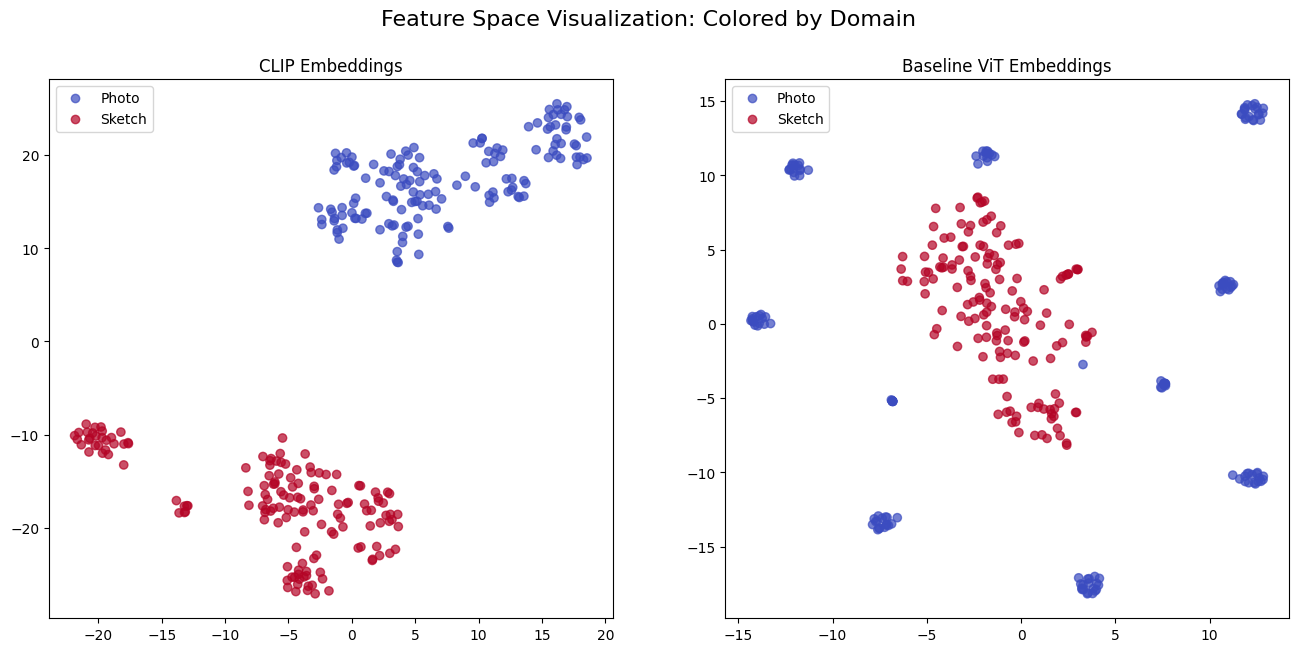

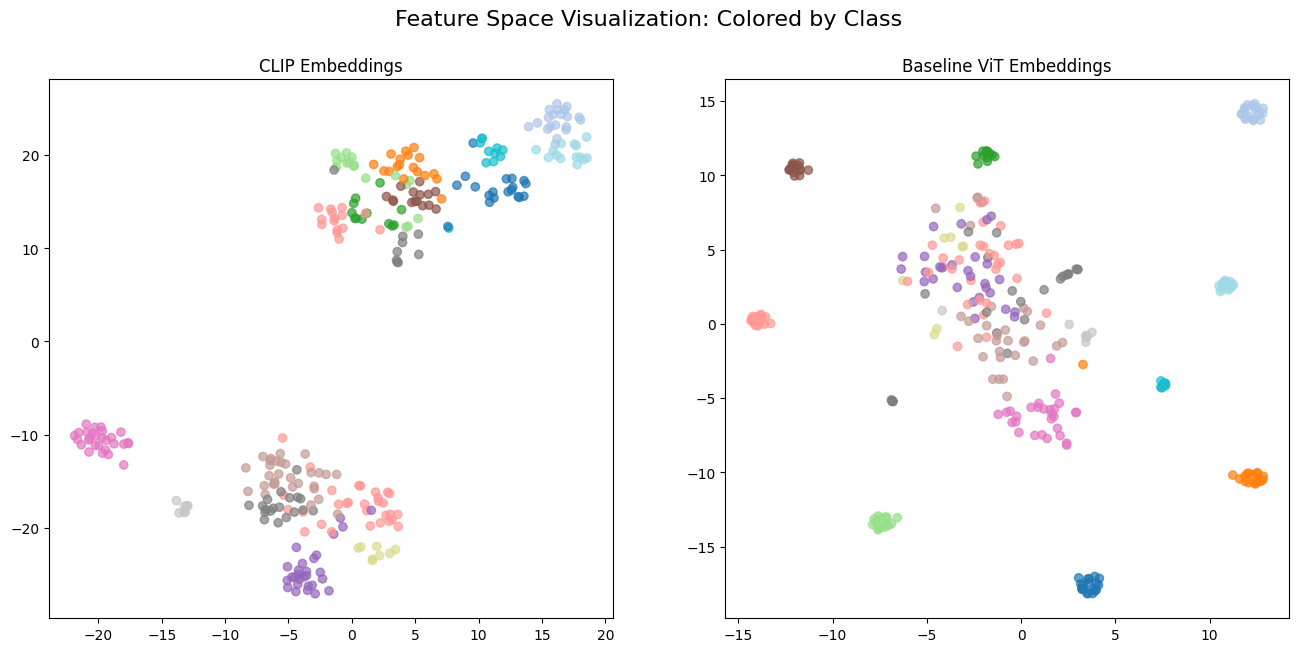

In [16]:
# --- 4. Visualize the Feature Spaces ---
print("\nStep 4: Generating plots...")

# Plot 1: Colored by Domain (Photo vs. Sketch)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Feature Space Visualization: Colored by Domain', fontsize=16)

scatter1 = ax1.scatter(clip_2d[:, 0], clip_2d[:, 1], c=domain_set, cmap='coolwarm', alpha=0.7)
ax1.set_title('CLIP Embeddings')
ax1.legend(handles=scatter1.legend_elements()[0], labels=['Photo', 'Sketch'])

scatter2 = ax2.scatter(baseline_2d[:, 0], baseline_2d[:, 1], c=domain_set, cmap='coolwarm', alpha=0.7)
ax2.set_title('Baseline ViT Embeddings')
ax2.legend(handles=scatter2.legend_elements()[0], labels=['Photo', 'Sketch'])
plt.show()


# Plot 2: Colored by Class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Feature Space Visualization: Colored by Class', fontsize=16)

# We have too many classes to show all in a legend, so we just show the plot
ax1.scatter(clip_2d[:, 0], clip_2d[:, 1], c=label_set, cmap='tab20', alpha=0.7)
ax1.set_title('CLIP Embeddings')

ax2.scatter(baseline_2d[:, 0], baseline_2d[:, 1], c=label_set, cmap='tab20', alpha=0.7)
ax2.set_title('Baseline ViT Embeddings')
plt.show()

## Shape vs Texture Bias in CLIP

--- Shape vs. Texture Bias Test ---


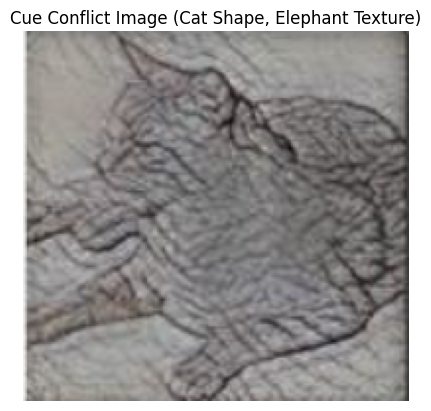


--- Testing CLIP ---
Similarity with 'a photo of a cat': 0.2603
Similarity with 'a photo of an elephant': 0.2637
✅ CLIP's Prediction: a photo of an elephant (Indicates a SHAPE bias)

--- Testing Baseline ViT ---
✅ Baseline ViT's Prediction: 'cat'


In [17]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. Load the Cue Conflict Image from a Local File ---
# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# UPDATE THIS PATH to the location of your uploaded file in the Kaggle notebook
cue_conflict_filepath = "/kaggle/input/texture-vs-shape/cat with elephant texture.png"
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^

try:
    cue_conflict_image = Image.open(cue_conflict_filepath).convert("RGB")
    print("--- Shape vs. Texture Bias Test ---")
    plt.imshow(cue_conflict_image)
    plt.title("Cue Conflict Image (Cat Shape, Elephant Texture)")
    plt.axis('off')
    plt.show()

    # --- 2. Test CLIP's Bias ---
    print("\n--- Testing CLIP ---")
    clip_model.eval()
    with torch.no_grad():
        text_prompts = ["a photo of a cat", "a photo of an elephant"]
        image_input = clip_processor(images=cue_conflict_image, return_tensors="pt").to(device)
        text_inputs = clip_processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
        image_features = clip_model.get_image_features(**image_input)
        text_features = clip_model.get_text_features(**text_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity_scores = (image_features @ text_features.T).squeeze()
        prediction_idx = similarity_scores.argmax().item()
        clip_prediction = text_prompts[prediction_idx]

        print(f"Similarity with '{text_prompts[0]}': {similarity_scores[0].item():.4f}")
        print(f"Similarity with '{text_prompts[1]}': {similarity_scores[1].item():.4f}")
        print(f"✅ CLIP's Prediction: {clip_prediction} (Indicates a SHAPE bias)")


    # --- 3. Test the Baseline ViT's Bias ---
    print("\n--- Testing Baseline ViT ---")
    baseline_model.eval()
    with torch.no_grad():
        inputs = baseline_processor(images=cue_conflict_image, return_tensors="pt").to(device)
        outputs = baseline_model(**inputs)
        logits = outputs.logits
        prediction_idx = torch.argmax(logits, dim=-1).item()
        baseline_prediction = cifar10_test_pil.classes[prediction_idx]
        
        print(f"✅ Baseline ViT's Prediction: '{baseline_prediction}'")

except FileNotFoundError:
    print(f"ERROR: File not found at '{cue_conflict_filepath}'")
    print("Please make sure you have uploaded the image and updated the path correctly.")

## Robustness Tests

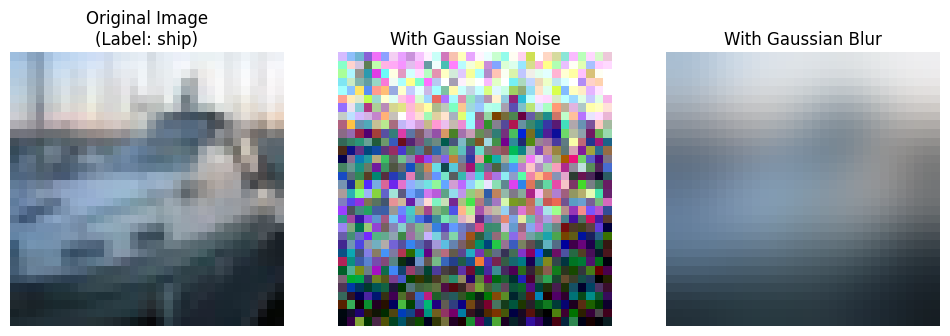

--- Testing on Original Image ---
True Label: ship
  - CLIP Prediction:     ship
  - Baseline Prediction: ship

--- Testing on Noisy Image ---
True Label: ship
  - CLIP Prediction:     ship
  - Baseline Prediction: frog

--- Testing on Blurred Image ---
True Label: ship
  - CLIP Prediction:     airplane
  - Baseline Prediction: cat



In [23]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup: Select an Image and Define Corruptions ---

# Let's select one clean image from CIFAR-10 to test. A ship is a good example.
clean_image, clean_label_idx = cifar10_test_pil[2] # Image index 7 is a ship
clean_label = cifar10_test_pil.classes[clean_label_idx]

# Define corruption functions
def add_gaussian_noise(image, std=0.2):
    """Adds Gaussian noise to a PIL image."""
    img_tensor = transforms.ToTensor()(image)
    noise = torch.randn_like(img_tensor) * std
    noisy_tensor = torch.clamp(img_tensor + noise, 0, 1)
    return transforms.ToPILImage()(noisy_tensor)

def apply_gaussian_blur(image, kernel_size=15, sigma=3):
    """Applies Gaussian blur to a PIL image."""
    return transforms.GaussianBlur(kernel_size, sigma=sigma)(image)

# Create the corrupted versions of the image
noisy_image = add_gaussian_noise(clean_image)
blurred_image = apply_gaussian_blur(clean_image)

# --- 2. Display the Images ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(clean_image)
axes[0].set_title(f"Original Image\n(Label: {clean_label})")
axes[0].axis('off')

axes[1].imshow(noisy_image)
axes[1].set_title("With Gaussian Noise")
axes[1].axis('off')

axes[2].imshow(blurred_image)
axes[2].set_title("With Gaussian Blur")
axes[2].axis('off')
plt.show()


# --- 3. Define a Unified Testing Function ---
def test_models(image, true_label):
    """Tests both CLIP and the baseline model on a single image and prints results."""
    
    # Test CLIP
    with torch.no_grad():
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        image_features = clip_model.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ ensembled_text_features.T)
        clip_pred_idx = similarity.argmax(dim=-1).item()
        clip_prediction = cifar10_test_pil.classes[clip_pred_idx]
        
    # Test Baseline ViT
    with torch.no_grad():
        inputs = baseline_processor(images=image, return_tensors="pt").to(device)
        outputs = baseline_model(**inputs)
        baseline_pred_idx = torch.argmax(outputs.logits, dim=-1).item()
        baseline_prediction = cifar10_test_pil.classes[baseline_pred_idx]

    print(f"True Label: {true_label}")
    print(f"  - CLIP Prediction:     {clip_prediction}")
    print(f"  - Baseline Prediction: {baseline_prediction}\n")

# --- 4. Run the Tests ---
print("--- Testing on Original Image ---")
test_models(clean_image, clean_label)

print("--- Testing on Noisy Image ---")
test_models(noisy_image, clean_label)

print("--- Testing on Blurred Image ---")
test_models(blurred_image, clean_label)